In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import os

import numpy as np
import pandas as pd
import tensorflow as tf

import atecml.data

from contextlib import contextmanager
from tqdm import tqdm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.externals import joblib
from sklearn.linear_model import LogisticRegressionCV
#build Models...
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
import lightgbm as lgb
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.externals import joblib
from imblearn.over_sampling import SMOTE, ADASYN
import random

plt.style.use('ggplot')

In [2]:
#train_df = pd.read_pickle('./01_train.dat')
train_df = atecml.data.load_train()

predictors = [x for x in train_df.columns if x not in atecml.data.NOT_FEATURE_COLUMNS]
DateFold={}

DateFold[0] = set(atecml.data.filter_date(train_df,start_date='2017-09-05',end_date='2017-09-12').index)
DateFold[1] = set(atecml.data.filter_date(train_df,start_date='2017-09-13',end_date='2017-09-20').index)
DateFold[2] = set(atecml.data.filter_date(train_df,start_date='2017-09-21',end_date='2017-09-28').index)
DateFold[3] = set(atecml.data.filter_date(train_df,start_date='2017-09-29',end_date='2017-10-06').index)
DateFold[4] = set(atecml.data.filter_date(train_df,start_date='2017-10-07',end_date='2017-10-14').index)
DateFold[5] = list(atecml.data.filter_date(train_df,start_date='2017-10-15',end_date='2017-11-24').index)

all_list = set(train_df.index) - set(DateFold[5])
len(all_list),len(DateFold[5])

(634284, 360447)

In [3]:
#WOE_LIST = joblib.load('./woe_feature.dat')
#CATE_LIST = WOE_LIST + atecml.data.CATE_FEATURE_LIST

CATE_LIST = atecml.data.CATE_FEATURE_LIST
categorical=[]
for item in predictors:
    if (item in CATE_LIST):
        categorical.append(item)


In [4]:
num_boosting_round = 3000
early_stop_round = 100

In [7]:
params = {
    
    'objective': 'binary',
    'metric': 'auc',
    'use_missing' : True,
    #'is_unbalance': True,
    'scale_pos_weight': 98,
    'learning_rate': 0.05,
    'num_leaves': 64,  # we should let it be smaller than 2^(max_depth)
    'max_depth': -1,  # -1 means no limit
    'min_child_samples': 600,  # Minimum number of data need in a child(min_data_in_leaf)
    'max_bin': 255,  # Number of bucketed bin for feature values
    'colsample_bytree': 0.4,
    'subsample': 0.85,  # Subsample ratio of the training instance.
    'subsample_freq': 1,  # frequence of subsample, <=0 means no enable
    'min_child_weight': 0.05,  # Minimum sum of instance weight(hessian) needed in a child(leaf)
    'subsample_for_bin': 200000,  # Number of samples for constructing bin
    'min_split_gain': 0,  # lambda_l1, lambda_l2 and min_gain_to_split to regularization
    'reg_alpha': 0.01,  # L1 regularization term on weights
    'reg_lambda': 0.1,  # L2 regularization term on weights
    'nthread': 40,
    'n_estimators': num_boosting_round,
    'verbose': -1,
}

rf = {
    'boosting_type': 'rf',
}
rf.update(params)

dart = {
    'boosting_type': 'dart',
}
dart.update(params)

gbdt = {
    'boosting_type': 'gbdt',
}
gbdt.update(params)

param_list = [rf,gbdt,dart]

In [8]:
model_list  =[]

for idx in tqdm(range(0,5)):
    
    Train_DataSet = train_df[train_df.index.isin(list(all_list - DateFold[idx]))].reset_index(drop=True)
    Normal_DF = Train_DataSet[Train_DataSet['label']==0]
    Fraud_DF = Train_DataSet[Train_DataSet['label']==1]
    
    number_record_fraud = len(Fraud_DF)
    number_record_normal = len(Normal_DF)
    #undersample
    random_normal_indices = np.array(np.random.choice(Normal_DF.index,number_record_fraud,replace=False))
    filter_list = list(random_normal_indices) + list(Fraud_DF.index)
    under_sample_train = Train_DataSet[Train_DataSet.index.isin(filter_list)].reset_index(drop=True)
    
    Val_DataSet = train_df[train_df.index.isin(DateFold[idx])].reset_index(drop=True)
    X_train = under_sample_train[predictors]
    y_train = under_sample_train['Fraud']

    X_test = Val_DataSet[predictors]
    y_test = Val_DataSet['Fraud']
    
    for item_params in (param_list):
        gbm = lgb.LGBMClassifier(**item_params)
        print('starting fit model...')
        gbm.fit(X_train, y_train, eval_set=[(X_test, y_test)],eval_metric='auc',early_stopping_rounds=early_stop_round,verbose=200,categorical_feature=categorical)
        model_list.append(gbm)  


  0%|          | 0/5 [00:00<?, ?it/s]

starting fit model...
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[5]	valid_0's auc: 0.897593
starting fit model...
Training until validation scores don't improve for 100 rounds.
[200]	valid_0's auc: 0.96948
[400]	valid_0's auc: 0.974757
[600]	valid_0's auc: 0.9763
[800]	valid_0's auc: 0.976984
Early stopping, best iteration is:
[843]	valid_0's auc: 0.977094
starting fit model...
Training until validation scores don't improve for 100 rounds.
[200]	valid_0's auc: 0.937008
[400]	valid_0's auc: 0.959992
[600]	valid_0's auc: 0.969813
[800]	valid_0's auc: 0.972039
[1000]	valid_0's auc: 0.973594
[1200]	valid_0's auc: 0.97461
[1400]	valid_0's auc: 0.975587
[1600]	valid_0's auc: 0.976012
[1800]	valid_0's auc: 0.976422
[2000]	valid_0's auc: 0.976845
[2200]	valid_0's auc: 0.977032



 20%|██        | 1/5 [01:30<06:02, 90.60s/it]

Early stopping, best iteration is:
[2142]	valid_0's auc: 0.977136
starting fit model...
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[98]	valid_0's auc: 0.930385
starting fit model...
Training until validation scores don't improve for 100 rounds.
[200]	valid_0's auc: 0.978639
[400]	valid_0's auc: 0.979736
Early stopping, best iteration is:
[471]	valid_0's auc: 0.980007
starting fit model...
Training until validation scores don't improve for 100 rounds.
[200]	valid_0's auc: 0.95714
[400]	valid_0's auc: 0.976609
[600]	valid_0's auc: 0.978877
[800]	valid_0's auc: 0.979502
[1000]	valid_0's auc: 0.979897
[1200]	valid_0's auc: 0.980046
[1400]	valid_0's auc: 0.980202



 40%|████      | 2/5 [02:29<03:44, 74.82s/it]

Early stopping, best iteration is:
[1353]	valid_0's auc: 0.980357
starting fit model...
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[71]	valid_0's auc: 0.953251
starting fit model...
Training until validation scores don't improve for 100 rounds.
[200]	valid_0's auc: 0.980126
[400]	valid_0's auc: 0.982094
[600]	valid_0's auc: 0.983093
[800]	valid_0's auc: 0.983508
[1000]	valid_0's auc: 0.983796
[1200]	valid_0's auc: 0.983968
[1400]	valid_0's auc: 0.984014
Early stopping, best iteration is:
[1322]	valid_0's auc: 0.984088
starting fit model...
Training until validation scores don't improve for 100 rounds.
[200]	valid_0's auc: 0.965094
[400]	valid_0's auc: 0.977247
[600]	valid_0's auc: 0.98054
[800]	valid_0's auc: 0.981612
[1000]	valid_0's auc: 0.982317
[1200]	valid_0's auc: 0.982769
[1400]	valid_0's auc: 0.983082
[1600]	valid_0's auc: 0.983286
[1800]	valid_0's auc: 0.983419
[2000]	valid_0's auc: 0.983512
[2200]	valid_0's auc: 0.983661



 60%|██████    | 3/5 [04:26<02:57, 88.82s/it]

[3000]	valid_0's auc: 0.984189
Did not meet early stopping. Best iteration is:
[2965]	valid_0's auc: 0.984202
starting fit model...
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[79]	valid_0's auc: 0.951732
starting fit model...
Training until validation scores don't improve for 100 rounds.
[200]	valid_0's auc: 0.978414
[400]	valid_0's auc: 0.980376
[600]	valid_0's auc: 0.981208
[800]	valid_0's auc: 0.981448
Early stopping, best iteration is:
[734]	valid_0's auc: 0.981567
starting fit model...
Training until validation scores don't improve for 100 rounds.
[200]	valid_0's auc: 0.96154
[400]	valid_0's auc: 0.97685
[600]	valid_0's auc: 0.979337
[800]	valid_0's auc: 0.980042
[1000]	valid_0's auc: 0.980796
[1200]	valid_0's auc: 0.981236



 80%|████████  | 4/5 [05:19<01:19, 79.95s/it]

Early stopping, best iteration is:
[1220]	valid_0's auc: 0.981454
starting fit model...
Training until validation scores don't improve for 100 rounds.
[200]	valid_0's auc: 0.915812
[400]	valid_0's auc: 0.917511
Early stopping, best iteration is:
[340]	valid_0's auc: 0.917678
starting fit model...
Training until validation scores don't improve for 100 rounds.
[200]	valid_0's auc: 0.980197
[400]	valid_0's auc: 0.983661
[600]	valid_0's auc: 0.984548
[800]	valid_0's auc: 0.984785
[1000]	valid_0's auc: 0.98512
[1200]	valid_0's auc: 0.985254
[1400]	valid_0's auc: 0.985213
Early stopping, best iteration is:
[1353]	valid_0's auc: 0.985303
starting fit model...
Training until validation scores don't improve for 100 rounds.
[200]	valid_0's auc: 0.94709
[400]	valid_0's auc: 0.973301
[600]	valid_0's auc: 0.980072
[800]	valid_0's auc: 0.982097
[1000]	valid_0's auc: 0.982932
[1200]	valid_0's auc: 0.983583
[1400]	valid_0's auc: 0.984091
[1600]	valid_0's auc: 0.984465
[1800]	valid_0's auc: 0.98479
[20


100%|██████████| 5/5 [07:15<00:00, 87.06s/it]


Early stopping, best iteration is:
[2608]	valid_0's auc: 0.985432


In [9]:
val_df = train_df[train_df.index.isin(DateFold[5])].reset_index(drop=True)
val_df1 = val_df.head(180000)
val_df2 = val_df[~val_df.index.isin(list(val_df1.index))]

In [22]:
val_r_neg=pd.DataFrame()
for idx in tqdm(range(0,len(model_list))):
    model_neg = model_list[idx]
    val_neg = model_neg.predict_proba(val_df[predictors])
    val_r_neg[idx] = pd.DataFrame(val_neg)[1]
    
    


100%|██████████| 15/15 [10:07<00:00, 40.49s/it]


Ant-Score: 0.40010676916506516


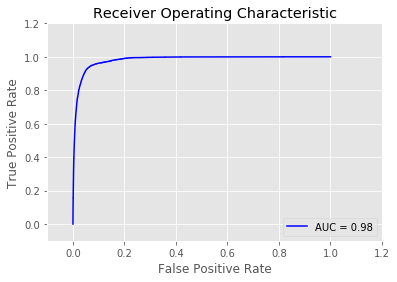

In [23]:
#pos_mean = val_r_pos.mean(axis=1)
neg_mean = val_r_neg.mean(axis=1)
_,_,_ = atecml.data.accuracy_validation(val_df['Fraud'],neg_mean)

In [13]:
def stack_result(X_train,model_list):
    with atecml.data.timer('Classification: Building Layer-1 Stack'):
        input_list = []
        for idx in tqdm(range(len(model_list))):
            model = model_list[idx]
            _temp_df = pd.DataFrame(model.predict_proba(X_train))[1]
            input_list.append(pd.DataFrame(_temp_df))
        input_predict= np.array(pd.concat(input_list,ignore_index=True,axis=1))
    return input_predict




In [14]:
level2_model_list  =[]
# use XGBOOST  as the model of the second layer
import xgboost as xgb
from xgboost.sklearn import XGBClassifier


for idx in range(0,5):
    
    Train_DataSet = train_df[train_df.index.isin(list(all_list - DateFold[idx]))].reset_index(drop=True)
    Normal_DF = Train_DataSet[Train_DataSet['label']==0]
    Fraud_DF = Train_DataSet[Train_DataSet['label']==1]
    
    number_record_fraud = len(Fraud_DF)
    number_record_normal = len(Normal_DF)
    #undersample
    random_normal_indices = np.array(np.random.choice(Normal_DF.index,number_record_fraud,replace=False))
    filter_list = list(random_normal_indices) + list(Fraud_DF.index)
    under_sample_train = Train_DataSet[Train_DataSet.index.isin(filter_list)].reset_index(drop=True)
    
    X_train = Train_DataSet[predictors]
    y_train = Train_DataSet['Fraud']
    
    model = XGBClassifier(
                         learning_rate =0.05,
                         n_estimators=400,
                         max_depth=3,
                         min_child_weight=1,
                         gamma=0,
                         subsample=0.8,
                         colsample_bytree=0.9,
                         objective= 'binary:logistic',
                         scoring='roc_auc',
                         scale_pos_weight= 98,
                         nthread=40,
                         seed=27)
    
    X_train_level2 = stack_result(X_train,model_list)
    model.fit(X_train_level2,y_train)  
    level2_model_list.append(model)
        


  0%|          | 0/15 [00:00<?, ?it/s]

[2018-07-06 14:40:08][Classification: Building Layer-1 Stack] Begin ...



100%|██████████| 15/15 [01:35<00:00,  6.35s/it]


[2018-07-06 14:41:44][Classification: Building Layer-1 Stack] End   ...[Elapsed: 95.35s]



  0%|          | 0/15 [00:00<?, ?it/s]

[2018-07-06 14:42:40][Classification: Building Layer-1 Stack] Begin ...



100%|██████████| 15/15 [01:38<00:00,  6.56s/it]


[2018-07-06 14:44:19][Classification: Building Layer-1 Stack] End   ...[Elapsed: 98.63s]



  0%|          | 0/15 [00:00<?, ?it/s]

[2018-07-06 14:45:19][Classification: Building Layer-1 Stack] Begin ...



100%|██████████| 15/15 [01:35<00:00,  6.36s/it]


[2018-07-06 14:46:54][Classification: Building Layer-1 Stack] End   ...[Elapsed: 95.53s]



  0%|          | 0/15 [00:00<?, ?it/s]

[2018-07-06 14:47:52][Classification: Building Layer-1 Stack] Begin ...



100%|██████████| 15/15 [01:39<00:00,  6.66s/it]


[2018-07-06 14:49:32][Classification: Building Layer-1 Stack] End   ...[Elapsed: 100.05s]



  0%|          | 0/15 [00:00<?, ?it/s]

[2018-07-06 14:50:29][Classification: Building Layer-1 Stack] Begin ...



100%|██████████| 15/15 [01:35<00:00,  6.39s/it]


[2018-07-06 14:52:05][Classification: Building Layer-1 Stack] End   ...[Elapsed: 96.06s]


In [15]:
val_df2_level2 = stack_result(val_df[predictors],model_list)
foo = stack_result(val_df2_level2,level2_model_list)



  0%|          | 0/15 [00:00<?, ?it/s]

[2018-07-06 14:52:57][Classification: Building Layer-1 Stack] Begin ...



100%|██████████| 15/15 [01:31<00:00,  6.10s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

[2018-07-06 14:54:29][Classification: Building Layer-1 Stack] End   ...[Elapsed: 91.56s]
[2018-07-06 14:54:29][Classification: Building Layer-1 Stack] Begin ...



100%|██████████| 5/5 [00:10<00:00,  2.16s/it]


[2018-07-06 14:54:40][Classification: Building Layer-1 Stack] End   ...[Elapsed: 10.81s]


Ant-Score: 0.4559683963271407


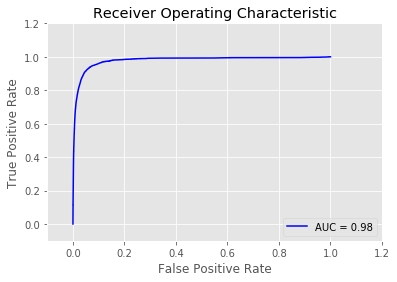

In [16]:
y_pred= pd.DataFrame(foo).min(axis=1)
_,_,_ = atecml.data.accuracy_validation(val_df['Fraud'],y_pred)

In [17]:
test_df = atecml.data.load_test()

In [18]:
test_df_level1 = stack_result(test_df[predictors],model_list)


  0%|          | 0/15 [00:00<?, ?it/s]

[2018-07-06 14:54:42][Classification: Building Layer-1 Stack] Begin ...



100%|██████████| 15/15 [13:42<00:00, 54.84s/it]


[2018-07-06 15:08:25][Classification: Building Layer-1 Stack] End   ...[Elapsed: 822.84s]


In [19]:
test_df_level2 = stack_result(test_df_level1,level2_model_list)


  0%|          | 0/5 [00:00<?, ?it/s]

[2018-07-06 15:08:25][Classification: Building Layer-1 Stack] Begin ...



100%|██████████| 5/5 [00:15<00:00,  3.14s/it]


[2018-07-06 15:08:41][Classification: Building Layer-1 Stack] End   ...[Elapsed: 15.71s]


In [20]:
y_pred= pd.DataFrame(test_df_level2).min(axis=1)

In [21]:
result=pd.DataFrame()
result['id'] = test_df['id']
result['score'] = y_pred

In [ ]:
result.to_csv('./0706_03.csv',index=False)

In [24]:
unknown_df =atecml.data.load_train()

In [32]:
unknown_df = unknown_df[unknown_df.label==-1].reset_index(drop=True)

In [33]:
un_level1 = stack_result(unknown_df[predictors],model_list)
un_level2 = stack_result(un_level1,level2_model_list)


  7%|▋         | 1/15 [00:00<00:01,  7.50it/s]

[2018-07-06 15:24:16][Classification: Building Layer-1 Stack] Begin ...



100%|██████████| 15/15 [00:09<00:00,  1.58it/s]

 60%|██████    | 3/5 [00:00<00:00, 21.48it/s]

[2018-07-06 15:24:26][Classification: Building Layer-1 Stack] End   ...[Elapsed: 9.52s]
[2018-07-06 15:24:26][Classification: Building Layer-1 Stack] Begin ...



100%|██████████| 5/5 [00:00<00:00, 21.29it/s]

[2018-07-06 15:24:26][Classification: Building Layer-1 Stack] End   ...[Elapsed: 0.24s]


In [34]:
un_pred= pd.DataFrame(un_level2).min(axis=1)

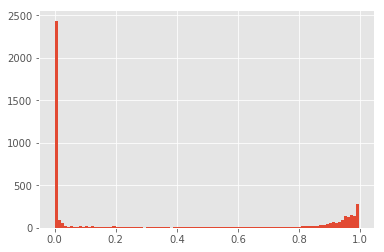

In [35]:
un_pred.hist(bins=100)

In [37]:
unresult=pd.DataFrame()
unresult['id'] = unknown_df['id']
unresult['score'] = un_pred

In [38]:
unresult.to_pickle('./reject_inf.dat')